Códigos para estudiar la visión en color humana
Vamos a analizar dos espectros que para la vista humana generan el mismo color. A cada uno vamos a multiplicarlos por las eficiencias tabuladas de los conos del ojo humano, e integrarlos en las longitudes de onda, obteniendo tres números. Vamos a comparar estos tres números entre los dos espectros, y no deberían tener diferencias significativas.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import matplotlib.ticker as ticker

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [7, 4]   # Ancho x Alto en pulgadas

from scipy.interpolate import UnivariateSpline

In [3]:

def cargar_datos(ruta):

    if ruta.endswith('.txt'):
        # Leer el archivo .txt como si fuera un CSV separado por ;
        df = pd.read_csv(ruta, sep=';', header=None, skiprows=1)# le pongo skiprows porque si no no sé por que no empieza igual que los csv

        # Convertir cada columna a un array unidimensional de numpy
        columna1_data = df[0].to_numpy()
        columna2_data = df[1].to_numpy()

    else:
        df = pd.read_csv(ruta, skiprows=53)

        # Seleccionar las dos primeras columnas a partir de la fila 54
        # Recuerda que en pandas los índices empiezan en 0, por lo que la fila 54 es el índice 53
        columna1_data = df.iloc[0:-1, 0]
        columna2_data = df.iloc[0:-1, 1]

    # Convertir los datos a arrays de NumPy
    array_columna1 = np.array(columna1_data)
    array_columna2 = np.array(columna2_data)

    #son strings asique los hago float
    lambdas = [float(x) for x in array_columna1]
    intensidad = [float(x) for x in array_columna2]

    return lambdas, intensidad



#para obtener sólo las intensidades
def cargar_señal(ruta):

    if ruta.endswith('.txt'):
        
        df = pd.read_csv(ruta, sep=';', header=None, skiprows=1)# le pongo skiprows porque si no no sé por que no empieza igual que los csv

        # Convertir cada columna a un array unidimensional de numpy
        columna2_data = df[1].to_numpy()

    else:
        df = pd.read_csv(ruta, skiprows=53)

        # Seleccionar las dos primeras columnas a partir de la fila 54
        # Recuerda que en pandas los índices empiezan en 0, por lo que la fila 54 es el índice 53
        columna2_data = df.iloc[0:-1, 1]

    # Convertir los datos a arrays de NumPy
    array_columna2 = np.array(columna2_data)

    #son strings asique los hago float
    intensidad = [float(x) for x in array_columna2]

    return intensidad


def desviaciones(ruta_carpeta_con_csvs, txt = False):

    if txt:
        archivos = sorted(glob.glob(ruta_carpeta_con_csvs + "/*.txt"))

        # Cargar todos los datos en una lista
        datos = [cargar_señal(f) for f in archivos]

        # Convertir a un array 2D: shape (num_archivos, largo_señal)
        matriz = np.stack(datos)

        # Calcular la desviación estándar en cada punto (a lo largo de los archivos)
        desv_std = np.std(matriz, axis=0)

    else:

        archivos = sorted(glob.glob(ruta_carpeta_con_csvs + "/*.csv"))

        # Cargar todos los datos en una lista
        datos = [cargar_señal(f) for f in archivos]

        # Convertir a un array 2D: shape (num_archivos, largo_señal)
        matriz = np.stack(datos)

        # Calcular la desviación estándar en cada punto (a lo largo de los archivos)
        desv_std = np.std(matriz, axis=0)


    return desv_std


def filtro_rango_eficiencia(lambdas, espectro, err_espectro, inferior, superior):

        
    # Encontrar el primer índice donde a >= 460
    idx_inferior = np.searchsorted(lambdas, inferior)
    idx_superior = np.searchsorted(lambdas, superior)

    lambdas_filtrados = lambdas[idx_inferior:idx_superior]
    espectro_filtrado = espectro[idx_inferior:idx_superior]
    err_espectro_filtrado = err_espectro[idx_inferior:idx_superior]

    return lambdas_filtrados, espectro_filtrado, err_espectro_filtrado


# le pasás la medición del promedio, la carpeta para los errores, la ruta del csv de las eficiencias y
# los límites con los que calculaste esa eficiencia, y te devuelve el espectro 'real' en ese intervalo

def eficientizar(ruta_espectro, ruta_carpeta_errores, ruta_eficiencia_csv, inferior, superior, txt =False):


    lambdas, espectro = cargar_datos(ruta_espectro)
    err_espectro = desviaciones(ruta_carpeta_errores, txt = txt)

    # normalizo el espectro medido
    espectro = espectro / np.max(espectro)
    err_espectro = err_espectro / np.max(espectro)

    #filtro en el rango elegido
    lambdas_filtrados, espectro_filtrado, err_espectro_filtrado = filtro_rango_eficiencia(lambdas, espectro, err_espectro, inferior, superior)
  

    #importo la eficiencia

    df_eficiencia = pd.read_csv(ruta_eficiencia_csv)

    columna1_data = df_eficiencia.iloc[0:-1, 0]
    columna2_data = df_eficiencia.iloc[0:-1, 1]
    columna3_data = df_eficiencia.iloc[0:-1, 2]

    # Convertir los datos a arrays de NumPy
    lambdas_eficiencia = np.array(columna1_data)
    eficiencia = np.array(columna2_data)
    err_eficiencia = np.array(columna3_data)


    # filtro la eficiencia en el rango elegido
    lambdas_eficiencias_filtrados, eficiencias_filtradas, err_eficiencias_filtradas = filtro_rango_eficiencia(lambdas_eficiencia, eficiencia, err_eficiencia, inferior, superior)

    #divido por la eficiencia

    espectro_real = espectro_filtrado / eficiencias_filtradas

    #propago el error del cociente

    err_espectro_real = espectro_real * np.sqrt( (err_espectro_filtrado/espectro_filtrado)**2 + (err_eficiencias_filtradas/eficiencias_filtradas)**2 )

    err_espectro_real = np.abs(err_espectro_real)

    return lambdas_filtrados, espectro_real, err_espectro_real



def integrar_señal(x, y, y_err):
    integral = np.trapz(y, x)

    # error en la integral

    # diferencias entre puntos consecutivos
    dx = np.diff(x)

    # pesos efectivos para cada punto
    weights = np.zeros_like(y)
    weights[1:-1] = (dx[:-1] + dx[1:]) / 2
    weights[0] = dx[0] / 2
    weights[-1] = dx[-1] / 2

    # varianza e incertidumbre de la integral
    integral_var = np.sum((weights * y_err)**2)
    integral_err = np.sqrt(integral_var)
    
    return integral, integral_err



# para eficientizar desde un array
def eficientizar_array(lambdas, espectro, err_espectro, ruta_eficiencia_csv, inferior, superior):

    # normalizo el espectro medido
    espectro = espectro / np.max(espectro)
    err_espectro = err_espectro / np.max(espectro)

    #filtro en el rango elegido
    lambdas_filtrados, espectro_filtrado, err_espectro_filtrado = filtro_rango_eficiencia(lambdas, espectro, err_espectro, inferior, superior)
  

    #importo la eficiencia

    df_eficiencia = pd.read_csv(ruta_eficiencia_csv)

    columna1_data = df_eficiencia.iloc[0:-1, 0]
    columna2_data = df_eficiencia.iloc[0:-1, 1]
    columna3_data = df_eficiencia.iloc[0:-1, 2]

    # Convertir los datos a arrays de NumPy
    lambdas_eficiencia = np.array(columna1_data)
    eficiencia = np.array(columna2_data)
    err_eficiencia = np.array(columna3_data)


    # filtro la eficiencia en el rango elegido
    lambdas_eficiencias_filtrados, eficiencias_filtradas, err_eficiencias_filtradas = filtro_rango_eficiencia(lambdas_eficiencia, eficiencia, err_eficiencia, inferior, superior)

    #divido por la eficiencia

    espectro_real = espectro_filtrado / eficiencias_filtradas

    #propago el error del cociente

    err_espectro_real = espectro_real * np.sqrt( (err_espectro_filtrado/espectro_filtrado)**2 + (err_eficiencias_filtradas/eficiencias_filtradas)**2 )

    err_espectro_real = np.abs(err_espectro_real)

    return lambdas_filtrados, espectro_real, err_espectro_real




#def graficar_espectro(ruta, ruta_errores, eff=True)



importamos las respuestas de los conos

y las interpolamos para después poder evaluarlas en las longitudes de onda que medimos

In [ ]:
# importamos

#S 

#M

#L

# interpolamos


#graficamos

Objeto Objeto
Azul
borrador - marcador

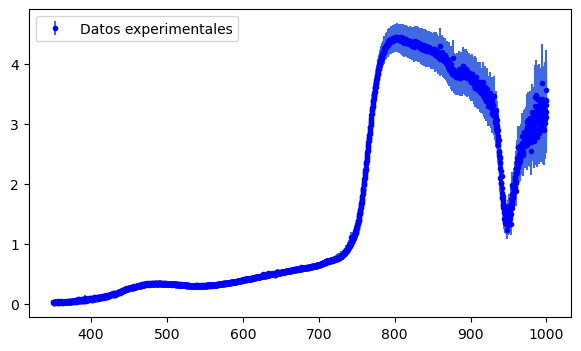

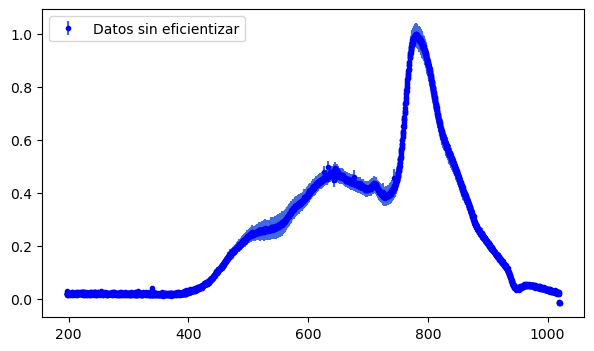

In [5]:

lambdas_filtrados_borrador, espectro_borrador, err_espectro_borrador = eficientizar("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/promedio.csv", 
                                                                   "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/desv", 
                                                                   "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
                                                                   350, 1000)


lambdas_filtrados_marcador, espectro_marcador, err_espectro_marcador = eficientizar("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/marcador/promedio.csv", 
                                                                   "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/marcador/desv", 
                                                                   "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
                                                                   350, 1000)



plt.errorbar(lambdas_filtrados_borrador, espectro_borrador, yerr = err_espectro_borrador, ecolor= 'royalblue', fmt = ".b", label = 'Datos experimentales')
plt.legend()
plt.show()



lambdas, espectro = cargar_datos("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/promedio.csv")
err_espectro = desviaciones("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/desv")

# normalizo el espectro medido
espectro = espectro / np.max(espectro)
err_espectro = err_espectro / np.max(espectro)


plt.errorbar(lambdas, espectro, yerr = err_espectro, ecolor= 'royalblue', fmt = ".b", label = 'Datos sin eficientizar')
plt.legend()
plt.show()



#plt.errorbar(lambdas_filtrados_marcador, espectro_marcador, yerr = err_espectro_marcador, ecolor= 'royalblue', fmt = ".b", label = 'Datos experimentales')
#plt.legend()
#plt.show()

#Imed = eff * I_real


Interpolo las mediciones de los conos y genero el csv con los lambdas y las respuestas de los conos



In [47]:
#data = pd.read_csv("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/respuesta conos tabulados/Copia de CIE_lms_cf_2deg.csv", header = None)
data = pd.read_csv("/Users/Mauri/Downloads/linss2_10e_1 - linss2_10e_1.csv", header = None)


long_onda = np.array(data[0])
L = np.array(data[1])
M = np.array(data[2])
S = np.array(data[3])



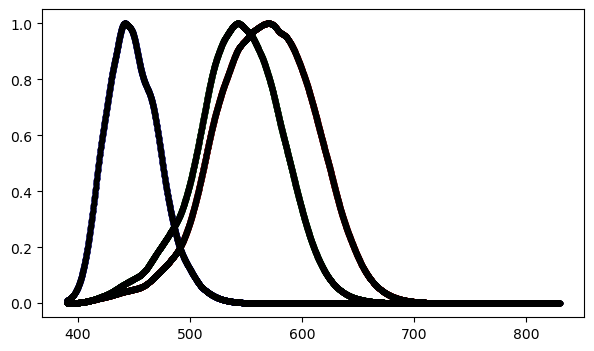

In [64]:
data = pd.read_csv("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/respuesta conos tabulados/Copia de CIE_lms_cf_2deg.csv", header = None)


long_onda = np.array(data[0])
L = np.array(data[1])
M = np.array(data[2])
S = np.array(data[3])


spline_cono_L = UnivariateSpline(long_onda, L, s=0) # calculo la interpolación
spline_cono_M= UnivariateSpline(long_onda, M, s=0)
spline_cono_S = UnivariateSpline(long_onda, S, s=0)

x_fit = np.linspace(long_onda[0], long_onda[-1], 5000)

interp_L = spline_cono_L(x_fit)
interp_M = spline_cono_M(x_fit)
interp_S = spline_cono_S(x_fit)

data = pd.read_csv("/Users/Mauri/Downloads/linss2_10e_1 - linss2_10e_1.csv", header = None)

long_onda = np.array(data[0])
L = np.array(data[1])
M = np.array(data[2])
S = np.array(data[3])

spline_cono_L = UnivariateSpline(long_onda, L, s=0) # calculo la interpolación
spline_cono_M= UnivariateSpline(long_onda, M, s=0)
spline_cono_S = UnivariateSpline(long_onda, S, s=0)

x_fit = np.linspace(long_onda[0], long_onda[-1], 5000)

interp_L_2 = spline_cono_L(x_fit)
interp_M_2 = spline_cono_M(x_fit)
interp_S_2 = spline_cono_S(x_fit)


plt.plot(x_fit, interp_L, ".r")
plt.plot(x_fit, interp_M, ".g")
plt.plot(x_fit, interp_S, ".b")

plt.plot(x_fit, interp_L_2, ".k")
plt.plot(x_fit, interp_M_2, ".k")
plt.plot(x_fit, interp_S_2, ".k")

plt.show()


# Función para analizar

Parámetros  
`lambdas`  
`señal` ( o sea la ruta)  
`err_señal` o sea la ruta de la carpeta con los csvs  
`eficiencia` ruta con la eficiencia
`inferior, superior` límites para el espectro y para la integración (lo ideal sería poner el espectro visible)  
`csv con las respuestas de los conos`  
`eficientizar` True or False  

`txt` True si la carpeta con los errores tienen txt, esto pasó porque al guardar en .spf2, lo pudimos pasar a .txt pero tienen un formato distinto a los csvs

devuelve integrales de S, M y L multiplicadas por el espectro

también agregamos unas funciones para pasar de sml a srgb y poder ver si los colores coinciden



grafica el espectro, ya sea eficientizado o no (esto capaz lo agrego después)

In [96]:
def lms_to_srgb(L, M, S, normalize=True):
    M_HPE = np.array([[0.4002,0.7076,-0.0808],
                      [-0.2263,1.1653,0.0457],
                      [0.0000,0.0000,0.9182]])
    M_inv = np.linalg.inv(M_HPE)
    XYZ = M_inv.dot([L, M, S])
    M_xyz_to_srgb = np.array([[3.2406,-1.5372,-0.4986],
                           [-0.9689,1.8758,0.0415],
                           [0.0557,-0.2040,1.0570]])
    rgb_linear = M_xyz_to_srgb.dot(XYZ)
    if normalize:
        rgb_linear /= np.max(rgb_linear)
    rgb_linear = np.clip(rgb_linear, 0, 1)
    a = 0.055
    rgb = np.where(rgb_linear <= 0.0031308,
                   12.92*rgb_linear,
                   (1+a)*rgb_linear**(1/2.4)-a)
    return (rgb*255).astype(int)



def lms_to_srgb_(L, M, S, normalize=True):
    """
    Convierte valores LMS (Stockman & Sharpe 2000) a sRGB (D65).

    Parámetros:
    ------------
    L, M, S : float o array
        Respuestas de los conos L, M, S.
    normalize : bool
        Si True, normaliza el máximo RGB a 1 (para evitar saturación visual).

    Retorna:
    --------
    np.array de enteros RGB en [0,255]
    """

    # ---LMS (Stockman & Sharpe 2000) → XYZ ---
    M_LMS_to_XYZ = np.array([
        [ 1.94735469, -1.41445123,  0.36476327],
        [ 0.68990272,  0.34832189, -0.03822362],
        [ 0.03663079, -0.16482503,  1.12886906]
    ])

    XYZ = M_LMS_to_XYZ @ np.array([L, M, S])

    # ---  XYZ → sRGB (D65 estándar) ---
    M_XYZ_to_sRGB = np.array([
        [ 3.2406, -1.5372, -0.4986],
        [-0.9689,  1.8758,  0.0415],
        [ 0.0557, -0.2040,  1.0570]
    ])

    rgb_linear = M_XYZ_to_sRGB @ XYZ

    # --- Normalización opcional ---
    if normalize and np.max(rgb_linear) > 0:
        rgb_linear = rgb_linear / np.max(rgb_linear)

    # --- Clip a [0,1] ---
    rgb_linear = np.clip(rgb_linear, 0, 1)

    # --- Corrección gamma (sRGB) ---
    a = 0.055
    rgb = np.where(rgb_linear <= 0.0031308,
                   12.92 * rgb_linear,
                   (1 + a) * np.power(rgb_linear, 1/2.4) - a)

    # --- Escalar a [0,255] y convertir a int ---
    return (rgb * 255).astype(int)



def color(rgb):
    rgb_norm = rgb / 255  # matplotlib usa [0,1]
    # Crear imagen de 1x1 píxel del color
    img = np.ones((10, 10, 3)) * rgb_norm  # cuadrado 10x10

    plt.imshow(img)
    plt.axis('off')
    plt.show()



def análisis(ruta_espectro, ruta_carpeta_errores, ruta_eficiencia_csv, inferior, superior, csv_conos, csv_halógena, carpeta_errores_halógena, dividir_halógena = False, eff = True, txt = False, graficar_espectro = False, color_espectro = 'black', color_error = 'grey'):


    #Analizo las mediciones, obtengo el espectro, ya sea usando la eficiencia del espectrómetro o no

    if eff:

        if dividir_halógena:
            #importo el espectro de la lámpara halógena
            espectro_lámpara = cargar_señal(csv_halógena)
            err_lámpara = desviaciones(carpeta_errores_halógena)

            #cargo el espectro medido
            lambdas, espectro = cargar_datos(ruta_espectro)
            err_espectro = desviaciones(ruta_carpeta_errores, txt = txt)

            # normalizo el espectro medido
            espectro = espectro / np.max(espectro)
            err_espectro = err_espectro / np.max(espectro)

            
            #divido por el espectro halógena
            espectro_dividido = espectro/espectro_lámpara
            err_espectro_dividivo = espectro * np.sqrt( (err_espectro/espectro)**2 + (err_lámpara/espectro_lámpara)**2 )


            lambdas_filtrados, espectro_real, err_espectro_real = eficientizar_array(lambdas, espectro_dividido, err_espectro_dividivo, ruta_eficiencia_csv, inferior, superior)

        else:
            lambdas_filtrados, espectro_real, err_espectro_real = eficientizar(ruta_espectro, ruta_carpeta_errores, ruta_eficiencia_csv, inferior, superior, txt = txt)

    else:

        if dividir_halógena:
            
            lambdas, espectro = cargar_datos(ruta_espectro)
            err_espectro = desviaciones(ruta_carpeta_errores, txt = txt)

            # normalizo el espectro medido
            espectro = espectro / np.max(espectro)
            err_espectro = err_espectro / np.max(espectro)

            #divido por el espectro halógena
            espectro_dividido = espectro/espectro_lámpara
            err_espectro_dividivo = espectro * np.sqrt( (err_espectro/espectro)**2 + (err_lámpara/espectro_lámpara)**2 )

            lambdas_filtrados, espectro_real, err_espectro_real = filtro_rango_eficiencia(lambdas, espectro_dividido, err_espectro_dividivo, inferior, superior)



        else:
            lambdas, espectro = cargar_datos(ruta_espectro)
            err_espectro = desviaciones(ruta_carpeta_errores, txt = txt)

            # normalizo el espectro medido
            espectro = espectro / np.max(espectro)
            err_espectro = err_espectro / np.max(espectro)

            #filtro en el rango elegido
            #lo llamo real aunque no tuvimos en cuenta la eficiencia para que ande el resto ya sea eficientizar True o Flase
            lambdas_filtrados, espectro_real, err_espectro_real = filtro_rango_eficiencia(lambdas, espectro, err_espectro, inferior, superior)
            


    espectro_real = espectro_real/np.max(espectro_real)
    err_espectro_real = err_espectro_real/np.max(espectro_real)


    #Importamos las respuestas de los conos
     #  
     # lo ideal sería que no estén normalizadas las tres, sino que una sí y las otras lo estén de manera acorde
     # y que ya haya interpolado y evaluado en los lambdas_med
     # filtrar en los lambdas filtrados
     #
     # rta_s, rta_m, rta_l
     # err_rta_s, ...
        

    data = pd.read_csv(csv_conos, header = None)

    long_onda = np.array(data[0])
    L = np.array(data[1])
    M = np.array(data[2])
    S = np.array(data[3])

    spline_cono_L = UnivariateSpline(long_onda, L, s=0) # calculo la interpolación
    spline_cono_M= UnivariateSpline(long_onda, M, s=0)
    spline_cono_S = UnivariateSpline(long_onda, S, s=0)

    rta_l = spline_cono_L(lambdas_filtrados)
    rta_m = spline_cono_M(lambdas_filtrados)
    rta_s = spline_cono_S(lambdas_filtrados)


    # multiplicamos por las respuestas e integramos
        
    producto_s = rta_s * espectro_real
    err_producto_s = err_espectro_real * rta_s
    #err_producto_s = producto_s * np.sqrt( (err_rta_s/rta_s)**2 + (err_espectro_real/espectro_real)**2 ) # si no tienen errores, uso el error de espectro real*rta_s

    producto_m = rta_m * espectro_real
    err_producto_m = err_espectro_real * rta_m

    producto_l = rta_l * espectro_real
    err_producto_l = err_espectro_real * rta_l


    integral_s, err_s = integrar_señal(lambdas_filtrados, producto_s, err_producto_s)
    integral_m, err_m = integrar_señal(lambdas_filtrados, producto_m, err_producto_m)
    integral_l, err_l = integrar_señal(lambdas_filtrados, producto_l, err_producto_l)


    print(f"Integral_S = {integral_s:.2f} ± {err_s:.2f}")
    print(f"Integral_M = {integral_m:.2f} ± {err_m:.2f}")
    print(f"Integral_L = {integral_l:.2f} ± {err_l:.2f}")



    #Pasamos a sRGB

    rgb = lms_to_srgb(integral_l, integral_m, integral_s, normalize=True)

    print("sRGB = ", rgb)


    #graficamos

    if  graficar_espectro:

        #creamos la imagen del color
        rgb_norm = rgb / 255  # matplotlib usa [0,1]
        # Crear imagen de 1x1 píxel del color
        img = np.ones((10, 10, 3)) * rgb_norm  # cuadrado 10x10


        color_espectro = rgb_norm
        color_error = np.append(rgb_norm, 0.4)  # Mismo color con transparencia (el cuarto elemento es el alpha (transparencia))


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [4, 8]})

        # Mostrar la imagen en el primer subplot
        ax1.imshow(img)
        ax1.axis('off')  # Quitar ejes para la imagen (opcional)

        # Graficar en el segundo subplot
        ax2.errorbar(lambdas_filtrados, espectro_real, yerr = err_espectro_real, fmt = ".", color = color_espectro, ecolor = color_error, markersize = 1, label = 'Datos experimentales')
        ax2.set_title('Espectro medido')

        #plt.tight_layout()
        plt.legend()
        plt.show()

    else:
        color(rgb)
        


    return integral_s, integral_m, integral_l


In [92]:
ruta_conoss = "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/respuesta conos tabulados/Copia de CIE_lms_cf_2deg_corregido.csv"

#ruta_conoss = "/Users/Mauri/Downloads/linss2_10e_1 - linss2_10e_1.csv"

# Objeto - Objeto

## rosa


Integral_S = 3.52 ± 0.02
Integral_M = 9.99 ± 0.01
Integral_L = 24.21 ± 0.02
sRGB =  [254   0  51]


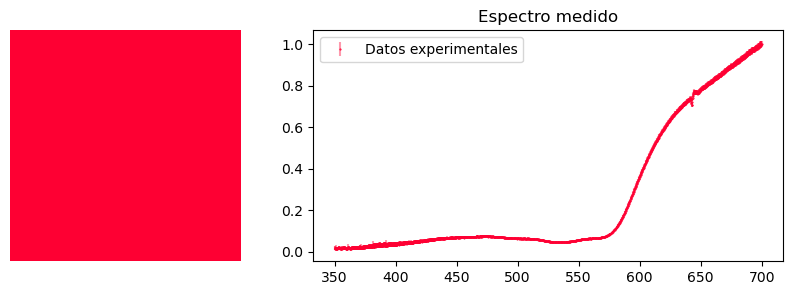

Integral_S = 12.27 ± 0.64
Integral_M = 6.86 ± 0.02
Integral_L = 10.74 ± 0.02
sRGB =  [254  66 180]


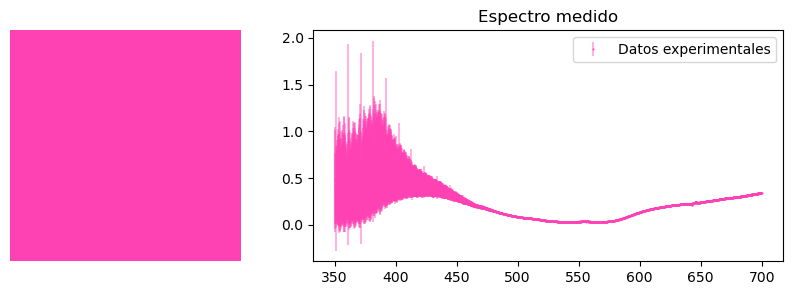

In [98]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/caja rosa/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/caja rosa/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv",   
         350, 700, "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/respuesta conos tabulados/Copia de CIE_lms_cf_2deg_corregido.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, graficar_espectro=True)

S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/caja rosa/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/caja rosa/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv",   
         350, 700, "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/respuesta conos tabulados/Copia de CIE_lms_cf_2deg_corregido.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, graficar_espectro=True)

Integral_S = 8.11 ± 0.04
Integral_M = 24.56 ± 0.02
Integral_L = 44.78 ± 0.03
sRGB =  [254  52  60]


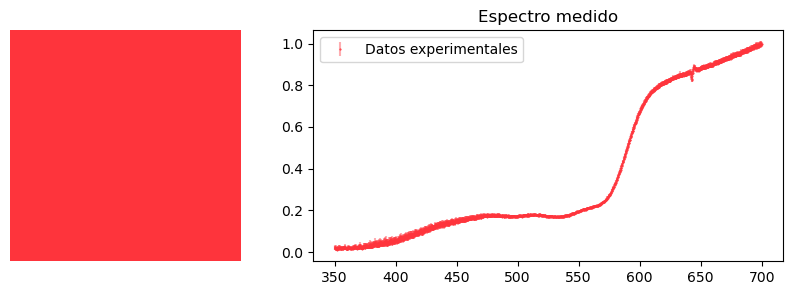

Integral_S = 26.13 ± 0.47
Integral_M = 13.53 ± 0.04
Integral_L = 17.03 ± 0.03
sRGB =  [254 127 232]


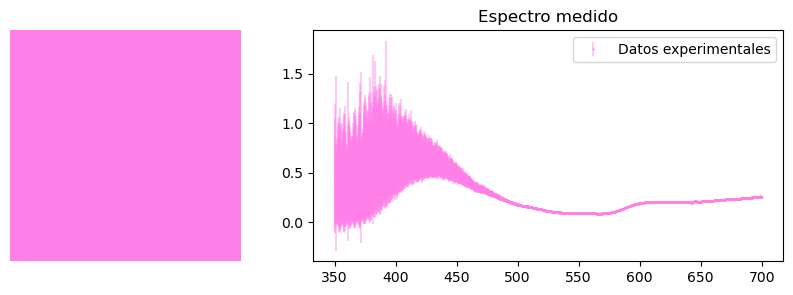

In [99]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/tijera rosa/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/tijera rosa/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, graficar_espectro=True)



S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/tijera rosa/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rosa (caja-tijera)/tijera rosa/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, graficar_espectro=True)


## azul

Integral_S = 21.45 ± 0.08
Integral_M = 47.63 ± 0.15
Integral_L = 63.42 ± 0.16
sRGB =  [254 140 103]


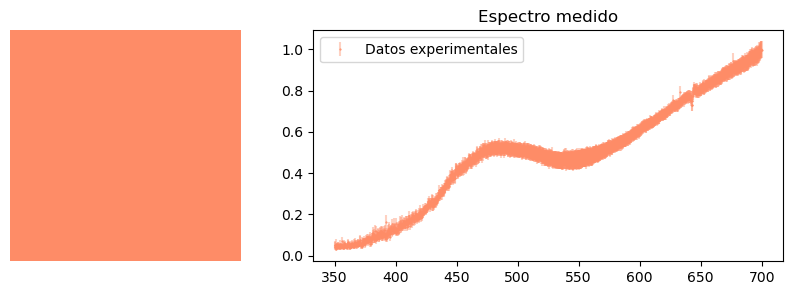

Integral_S = 22.10 ± 0.28
Integral_M = 10.68 ± 0.15
Integral_L = 10.37 ± 0.16
sRGB =  [180 165 254]


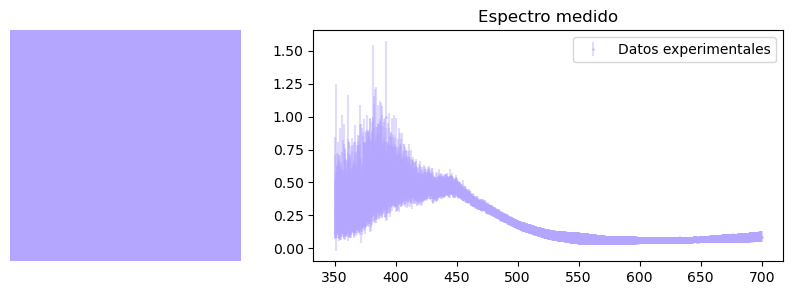

In [101]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, graficar_espectro = True)


S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/borrador/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, graficar_espectro = True)


Integral_S = 9.73 ± 0.05
Integral_M = 36.41 ± 0.04
Integral_L = 53.34 ± 0.04
sRGB =  [254 116  61]


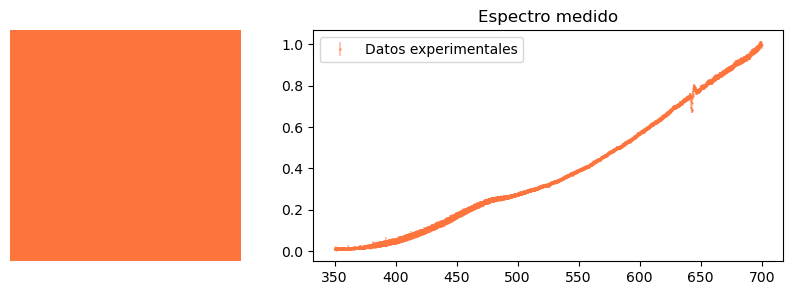

Integral_S = 34.67 ± 0.56
Integral_M = 24.27 ± 0.07
Integral_L = 26.52 ± 0.06
sRGB =  [254 191 249]


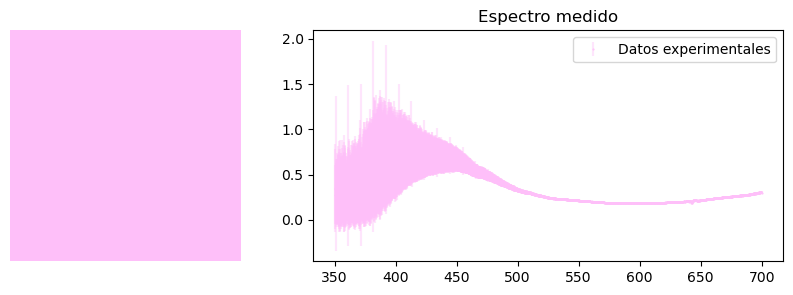

In [102]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/marcador/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/marcador/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, graficar_espectro = True)



S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/marcador/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/azul (borrador-marcador)/marcador/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, graficar_espectro = True)

## rojo

Integral_S = 1.05 ± 0.01
Integral_M = 6.49 ± 0.01
Integral_L = 21.56 ± 0.02
sRGB =  [254   0  19]


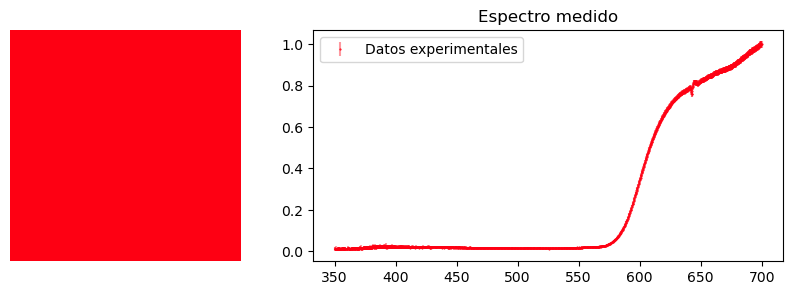

Integral_S = 5.62 ± 0.30
Integral_M = 4.39 ± 0.02
Integral_L = 10.94 ± 0.02
sRGB =  [254   0 107]


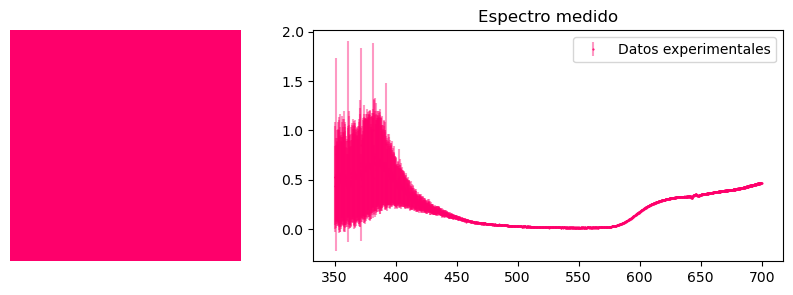

In [103]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/lápiz/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/lápiz/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, graficar_espectro = True)


S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/lápiz/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/lápiz/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, graficar_espectro = True)

Integral_S = 3.84 ± 0.02
Integral_M = 20.56 ± 0.02
Integral_L = 44.09 ± 0.03
sRGB =  [254   0  29]


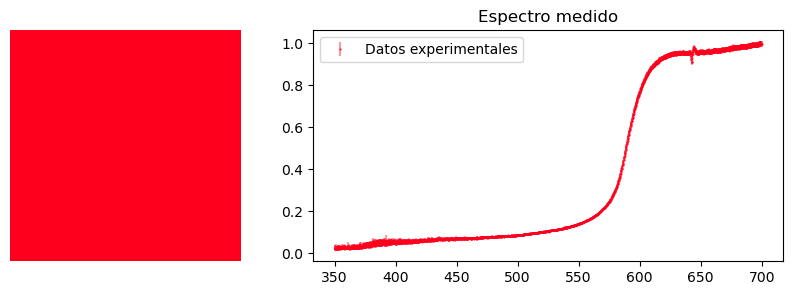

Integral_S = 9.51 ± 0.31
Integral_M = 7.59 ± 0.02
Integral_L = 11.89 ± 0.03
sRGB =  [254  78 152]


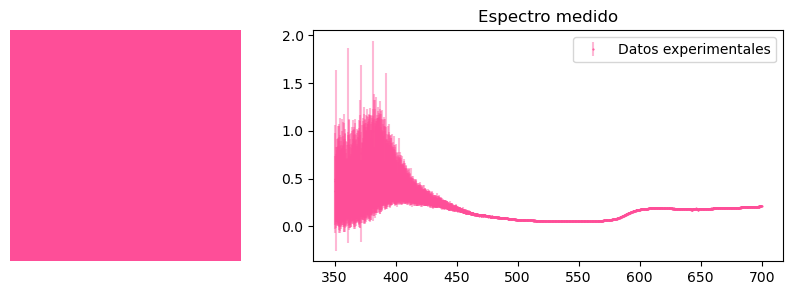

In [104]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/microfibra/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/microfibra/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, graficar_espectro = True)


S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/microfibra/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/rojo (lápiz-microfibra)/microfibra/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, graficar_espectro = True)




## verde

Integral_S = 10.59 ± 0.05
Integral_M = 54.92 ± 0.07
Integral_L = 73.15 ± 0.07
sRGB =  [254 145  45]


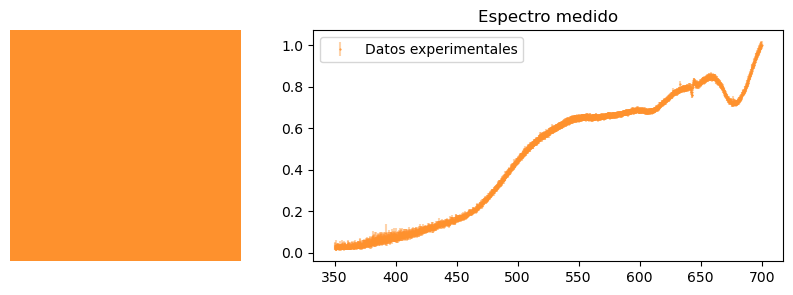

Integral_S = 17.30 ± 0.26
Integral_M = 17.91 ± 0.06
Integral_L = 18.70 ± 0.06
sRGB =  [254 227 228]


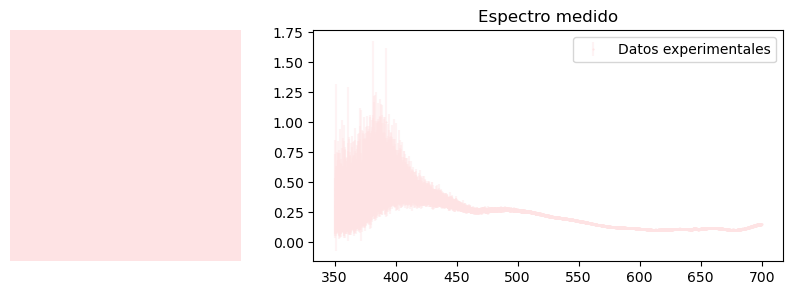

In [105]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/tijera/promedio_auto.txt", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/tijera/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, txt = False, graficar_espectro = True)



S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/tijera/promedio_auto.txt", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/tijera/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, txt = False, graficar_espectro = True)



Integral_S = 7.70 ± 0.17
Integral_M = 37.15 ± 0.76
Integral_L = 54.31 ± 1.04
sRGB =  [254 117  45]


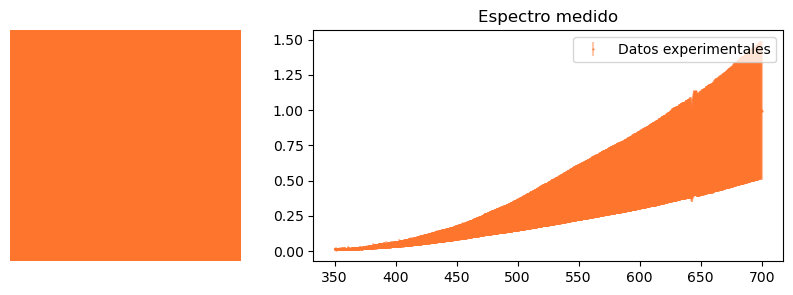

Integral_S = 27.89 ± 0.55
Integral_M = 24.67 ± 0.76
Integral_L = 27.51 ± 1.04
sRGB =  [254 189 217]


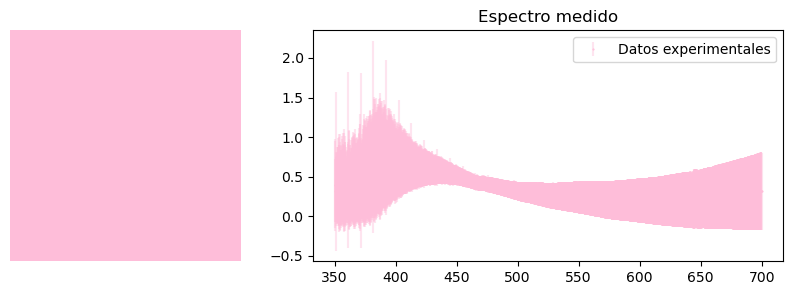

In [106]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/vaso/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/vaso/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, txt = False, graficar_espectro = True)


S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/vaso/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/obj-obj/verde(tijera-vaso)/vaso/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=True, 
         eff = True, txt = False, graficar_espectro = True)


# Celular Celular

## Azul

Integral_S = 14.39 ± 0.14
Integral_M = 3.83 ± 0.03
Integral_L = 2.66 ± 0.01
sRGB =  [  0 126 254]


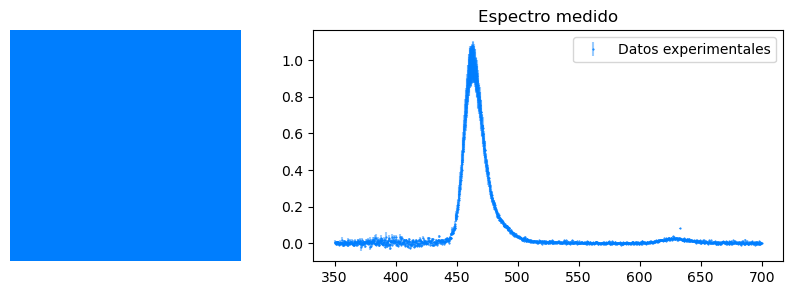

In [78]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/azul/Martu/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/azul/Martu/desv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, graficar_espectro = True)


Integral_S = 17.01 ± 0.19
Integral_M = 3.49 ± 0.03
Integral_L = 2.15 ± 0.02
sRGB =  [  0 105 254]


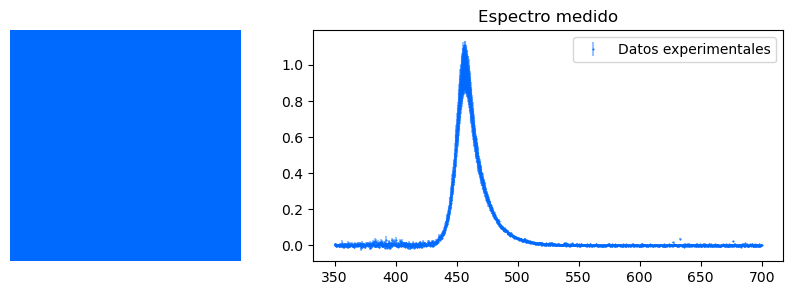

In [79]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/azul/Lu/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/azul/Lu/desv_txt2", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, txt = True, graficar_espectro = True)


## rosa

Integral_S = 3.02 ± 0.01
Integral_M = 4.12 ± 0.00
Integral_L = 14.25 ± 0.01
sRGB =  [254   0  65]


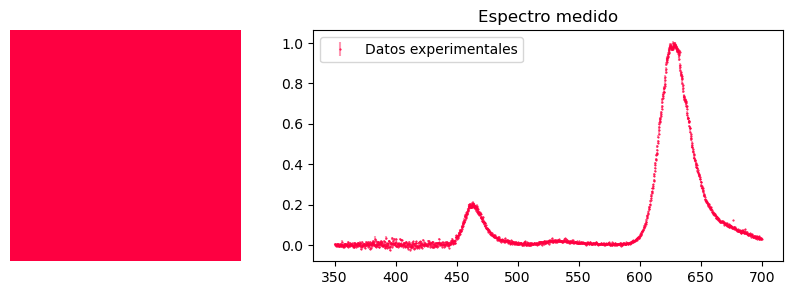

In [80]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/rosa/Martu/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/rosa/Martu/desv_txt", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss, 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, txt = True, graficar_espectro = True)


Integral_S = 4.59 ± 0.03
Integral_M = 7.91 ± 0.01
Integral_L = 23.63 ± 0.02
sRGB =  [254   0  62]


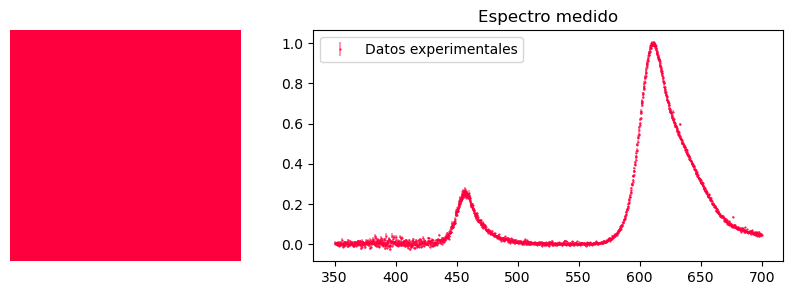

In [81]:
S, M, L = análisis("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/rosa/Lu/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/objeto-celular/cel-cel/rosa/Lu/desv_txt", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/eficiencia.csv", 
         350, 700, ruta_conoss,
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv", 
         "/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error",dividir_halógena=False, 
         eff = True, txt = True, graficar_espectro = True)


In [ ]:
rgb = lms_to_srgb(L, M, S, normalize=True)

print("sRGB = ", rgb)

color(rgb)